<a href="https://colab.research.google.com/github/CorpuzKB/PML-Advance-Topics-notebooks/blob/main/HMM_Inference__TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hidden Markov Model (HMM) State Inference
The HMM_Inference class includes the methods listed below that are capable of inferring from batched samples. Implemented the following from the book, [Probabilistic Machine Learning: Advanced Topics (Murphy K., 2023)](https://probml.github.io/pml-book/book2.html):
1.   Forward-Backwards algorithm
2.   The Viterbi algorithm


In [1]:
!pip install tqdm -q

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats
from tqdm import tqdm

tfd = tfp.distributions
sns.set(rc={"figure.dpi":80, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")
set_matplotlib_formats('retina')

In [880]:
class HMM_inference:
  def __init__(self, λ, y):
    local_evidence = tf.gather(λ, y, axis=1)
    self.local_evidence = tf.transpose(local_evidence, [1, 2, 0])[..., tf.newaxis]
    
  def normalize(self, x):
    return x/(tf.math.reduce_sum(x, 1, keepdims=True))

  def Forward(self, A, a_t, steps):
    for i in tqdm(range(steps)):
      a_t = self.local_evidence[:, i] * (tf.transpose(A) @ a_t)
      a_t = self.normalize(a_t)
      if i == 0: 
        a = a_t
      else: 
        a = tf.concat([a, a_t], 2)
    return tf.transpose(a, [0, 2, 1])[..., tf.newaxis]

  def Backward(self, A, a, steps, num_states):
    batch_dims = self.local_evidence.shape[0]
    β_t = tf.fill([batch_dims, num_states, 1], 1.)
    for i in tqdm(range(steps - 1, -1, -1)):
      g_t = a[:, i] * β_t
      g_t = self.normalize(g_t)
      β_t = A @ (self.local_evidence[:, i] * β_t)
      β_t = self.normalize(β_t)
      if i == steps - 1: 
        β = β_t
        g = g_t
      else: 
        β = tf.concat([β, β_t], 2)
        g = tf.concat([g, g_t], 2)
    β = tf.reverse(β, [-1])
    g = tf.reverse(g, [-1])
    return tf.transpose(β, [0, 2, 1])[..., tf.newaxis], tf.transpose(g, [0, 2, 1])[..., tf.newaxis]

  def Viterbi(self, A, a, steps, num_states):
    A = tf.transpose(A)
    batch_dims = self.local_evidence.shape[0]
    δ_t = - tf.math.log(self.local_evidence[:, 0]) - tf.math.log(a)
    λ = - tf.math.log(self.local_evidence)
    λ = tf.tile(λ, [1, batch_dims, 1, num_states]) 
    A = - tf.math.log(A)
    for i in tqdm(range(1, steps)):
      δ_ = A + λ[:, i] + tf.tile(tf.transpose(δ_t, [0, 2, 1]), [1, num_states, 1])
      min_index = tf.math.argmin(δ_, 2)[..., tf.newaxis]
      δ_t = tf.gather_nd(δ_, min_index, 2)[..., tf.newaxis]
      if i == 1: 
        node = min_index
      else: 
        node = tf.concat([node, min_index], 2)
    node = tf.transpose(node, [0, 2, 1])
    state_t = tf.math.argmin(tf.reshape(δ_, [batch_dims, num_states*num_states]), 1)
    state_t = tf.cast(state_t/num_states, tf.int64)[..., tf.newaxis]
    MAP_path = state_t
    for i in range(steps - 2, -1, -1):
      state_t = tf.gather(node[:, i], state_t[..., 0], axis=1, batch_dims=1)[..., tf.newaxis]
      MAP_path = tf.concat([MAP_path, state_t], 1)
    return tf.reverse(MAP_path, [-1])

## Casino Dice Roll State Inference

### Generate Sample Data

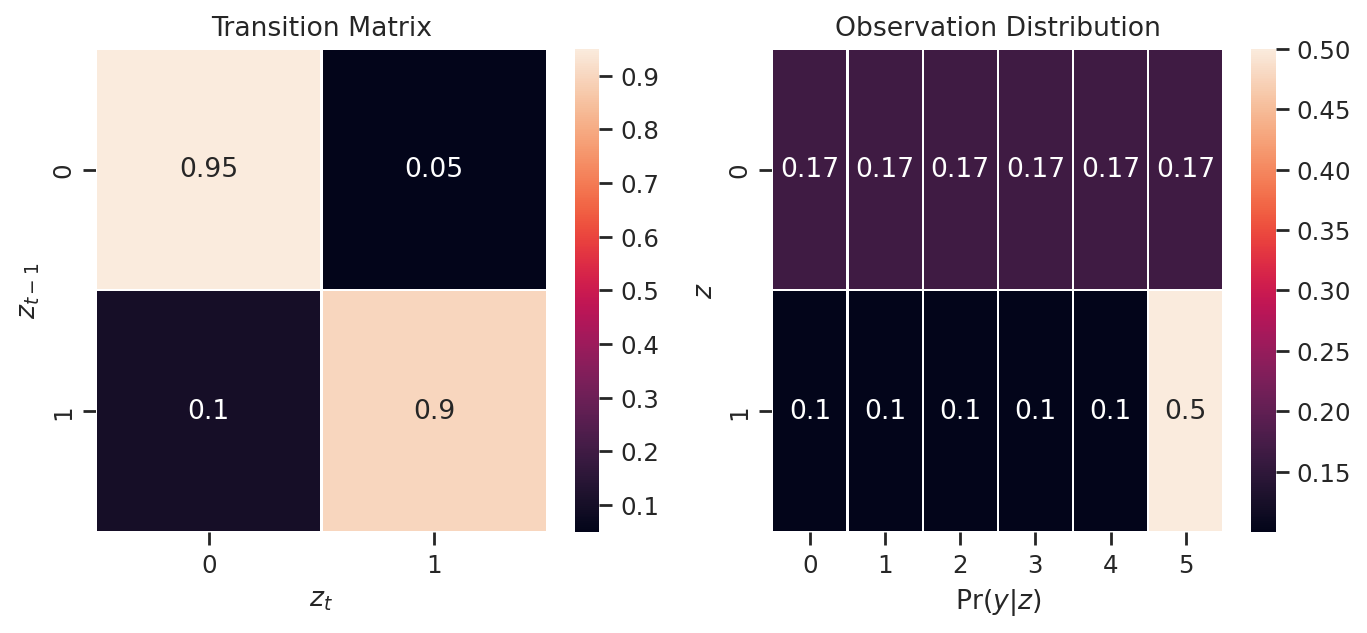

In [843]:
num_states = 2

states_0 = tf.fill([num_states, 1], 1/num_states)
A = tf.constant([
    [0.95, 0.05], (0.1, 0.9)
])

λ = tf.stack([
    tf.squeeze(tf.constant(tf.fill([1, 6], 1/6))),
    tf.constant([*[1/10 for _ in range(5)], 5/10])
    ])
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.heatmap(A, annot=True, linewidth=.5, ax=axes[0])
sns.heatmap(λ, annot=True, linewidth=.5, ax=axes[1])
axes[0].set(xlabel='$z_{t}$', ylabel='$z_{t-1}$', title='Transition Matrix')
axes[1].set(xlabel='$\Pr(y|z)$', ylabel='$z$', title='Observation Distribution')
plt.show()

In [844]:
def CasinoHMM(A, λ, state_0, steps, batch=1):
  state_t = tfd.Categorical(probs=tf.squeeze(state_0)).sample([batch, 1])
  transition_distribution = tfd.Categorical(probs=A).sample([batch, steps])
  observation_distribution = tfd.Categorical(probs=λ).sample([batch, steps])

  for i in range(steps):
    state_t = tf.gather_nd(transition_distribution[:, i], state_t, 1)[:, tf.newaxis]
    obs_t = tf.gather_nd(observation_distribution[:, i], state_t, 1)[:, tf.newaxis]
    if i == 0: 
      state = state_t
      obs = obs_t
    else: 
      state = tf.concat([state, state_t], 1)
      obs = tf.concat([obs, obs_t], 1)
  return state, obs

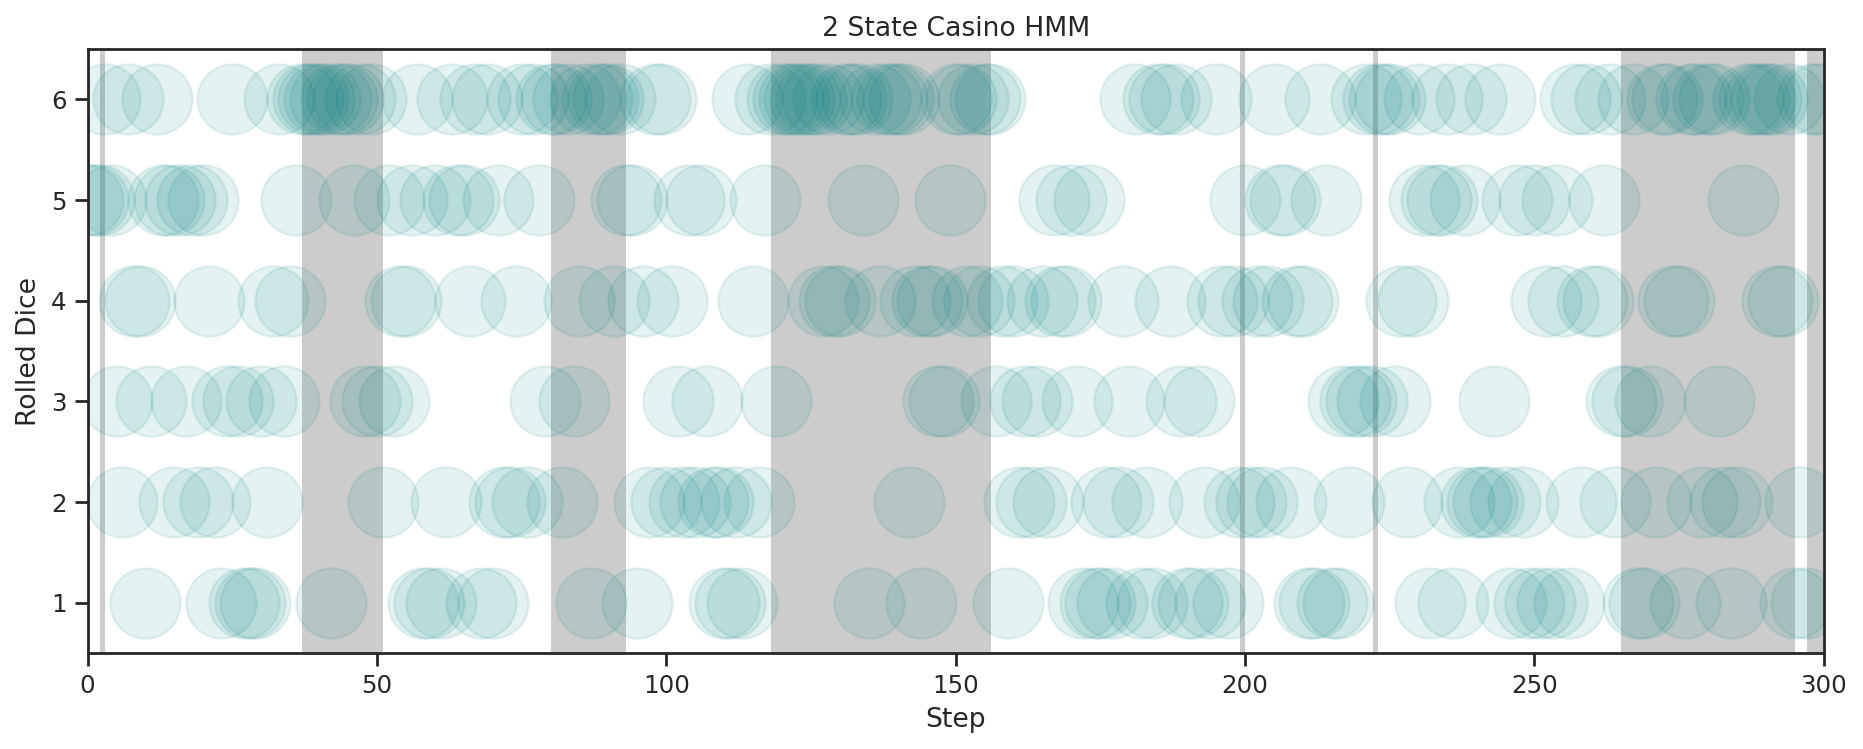

In [861]:
batch_dims = 1
steps = 300
true_states, observations = CasinoHMM(A, λ, states_0, steps, batch=batch_dims)
plt.figure(figsize=(14, 5))
plt.imshow(true_states[None, 0, :], extent=(0, steps, 0, 7), cmap='Greys', alpha=0.2, aspect='auto')
plt.scatter(tf.range(steps), observations[0] + 1, color="teal", alpha=0.1, s=1000)
plt.title("{} State Casino HMM".format(num_states)); plt.ylabel('Rolled Dice');  plt.xlabel('Step'); plt.ylim(0.5, 6.5); plt.show()

### Perform Inference

100%|██████████| 300/300 [00:00<00:00, 2059.43it/s]


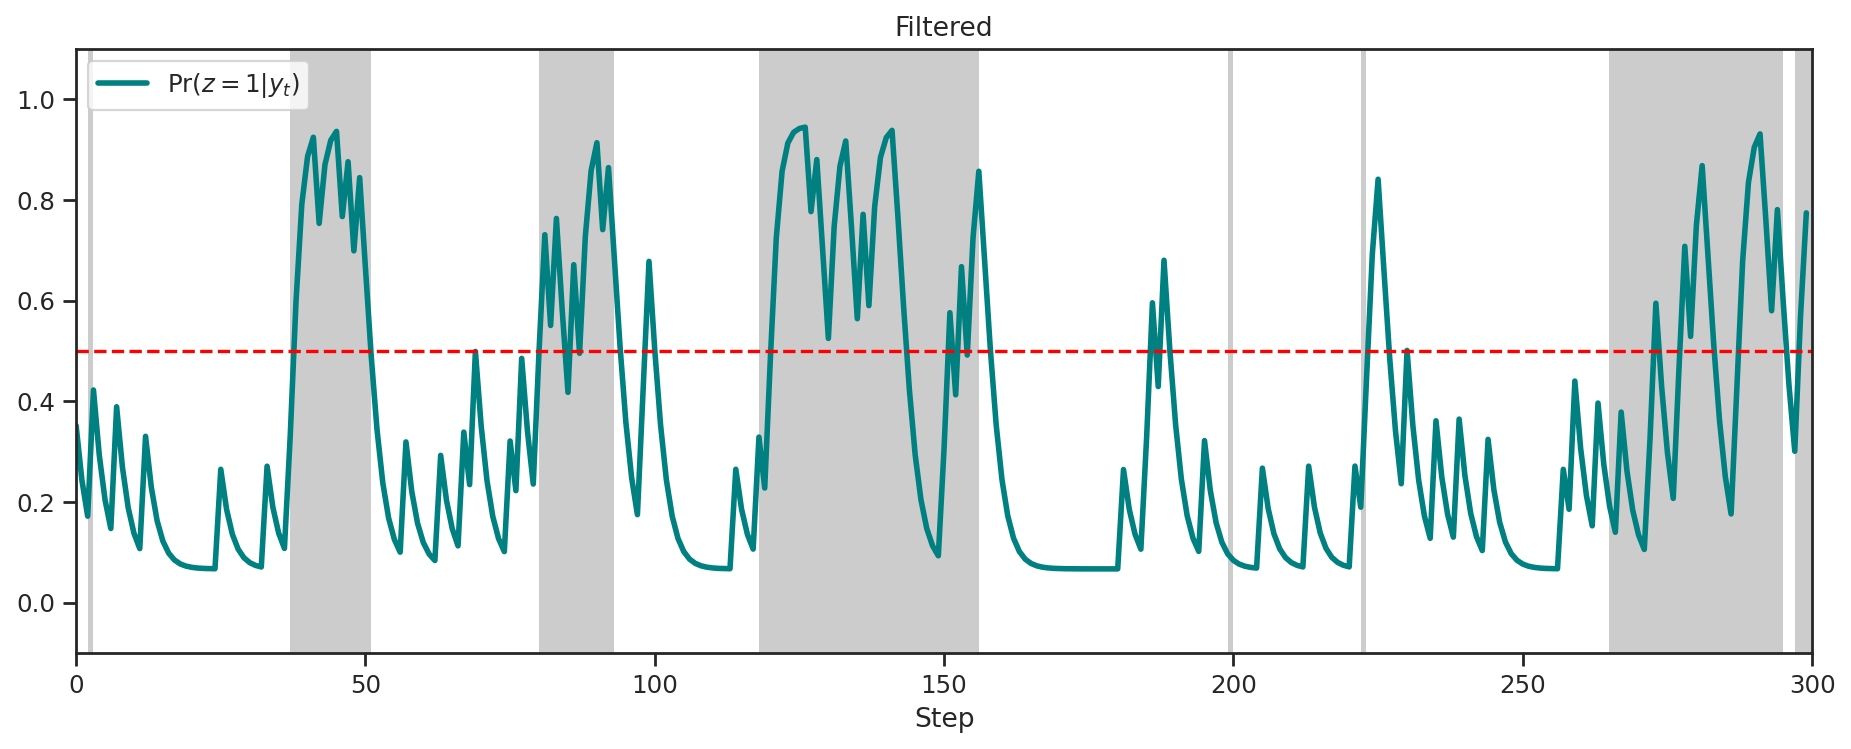

In [882]:
Inference = HMM_inference(λ, observations)

prob_filtered = Inference.Forward(A, states_0, steps)
plt.figure(figsize=(14, 5))
plt.imshow(true_states[None, 0, :], extent=(0, steps, -0.1, 1.1), cmap='Greys', alpha=0.2, aspect='auto')
plt.plot(prob_filtered[0, :, 1], label='$\Pr(z=1|y_t)$', color="teal", linewidth=2.5)
plt.axhline(0.5, color = 'red', linestyle='--')
plt.title("Filtered"); plt.xlabel('Step'); plt.legend(loc='upper left'); plt.ylim(-0.1, 1.1); plt.show()

100%|██████████| 300/300 [00:00<00:00, 1455.65it/s]


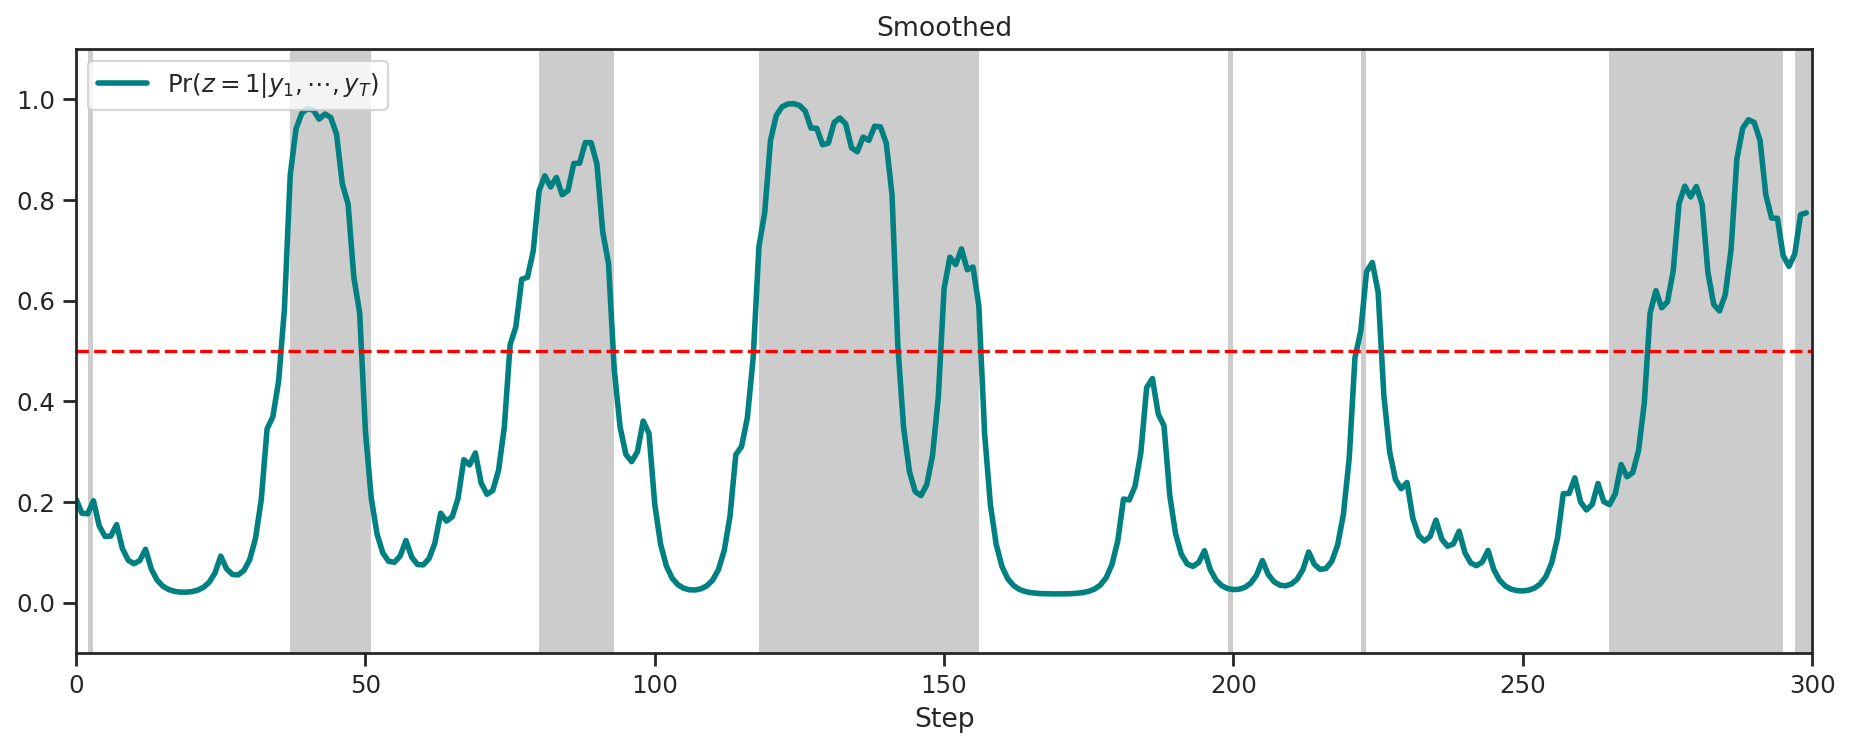

In [876]:
β, prob_smoothed = Inference.Backward(A, prob_filtered, steps, num_states)
plt.figure(figsize=(14, 5))
plt.imshow(true_states[None, 0, :], extent=(0, steps, -0.1, 1.1), cmap='Greys', alpha=0.2, aspect='auto')
plt.plot(prob_smoothed[0, :, 1], label='$\Pr(z=1|y_1,\cdots, y_T)$', color="teal", linewidth=2.5)
plt.axhline(0.5, color = 'red', linestyle='--')
plt.title("Smoothed"); plt.xlabel('Step'); plt.legend(loc='upper left'); plt.ylim(-0.1, 1.1); plt.show()

100%|██████████| 299/299 [00:01<00:00, 194.42it/s]


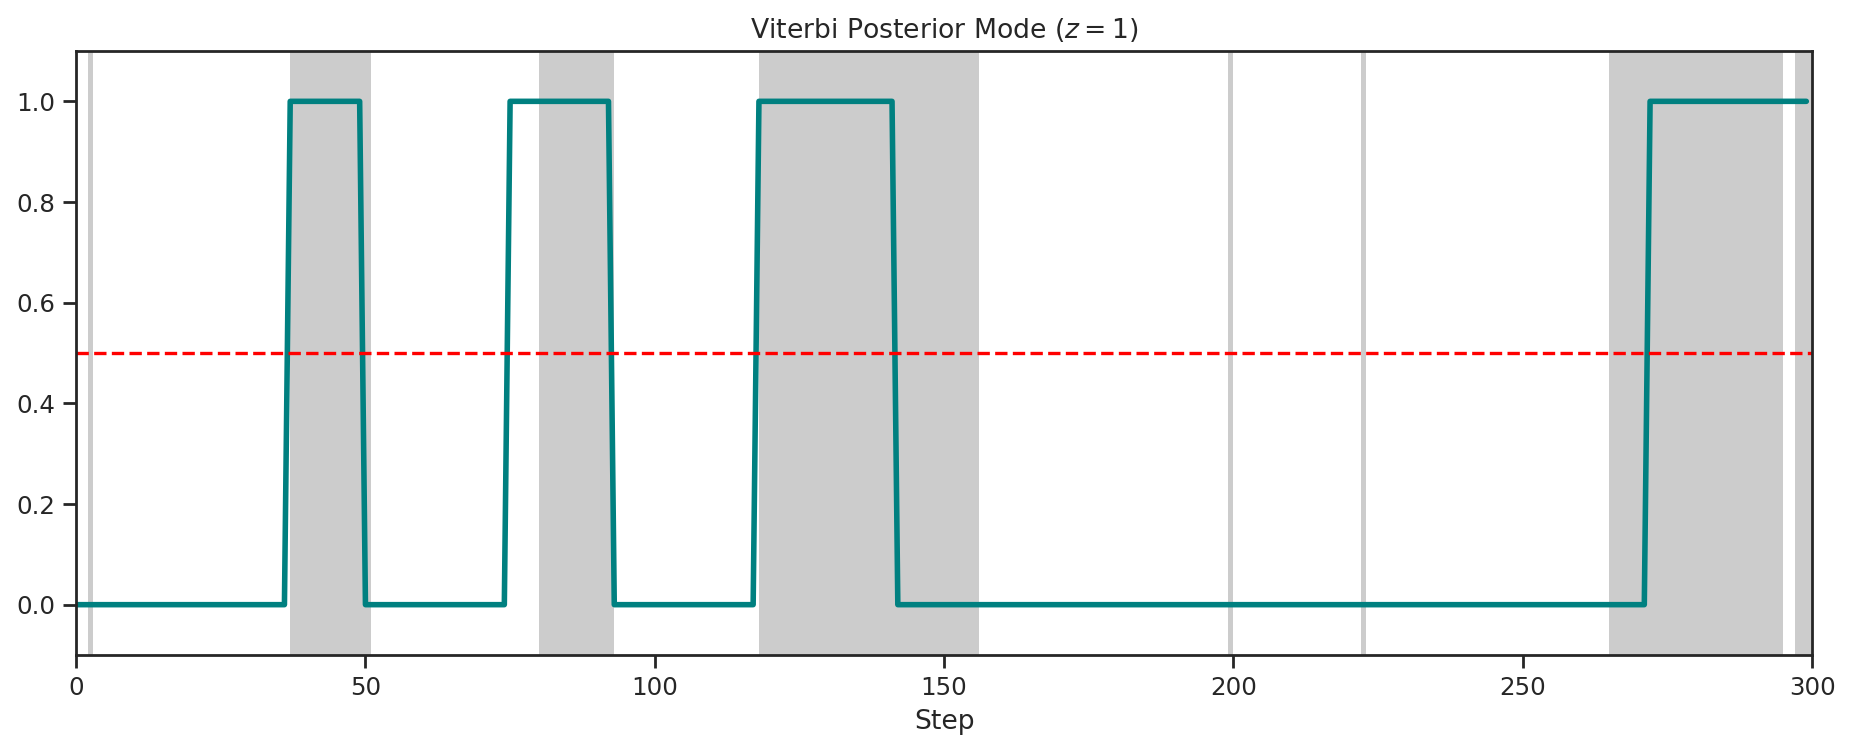

In [883]:
states_Viterbi = Inference.Viterbi(A, states_0, steps, num_states)
plt.figure(figsize=(14, 5))
plt.imshow(true_states[None, 0, :], extent=(0, steps, -0.1, 1.1), cmap='Greys', alpha=0.2, aspect='auto')
plt.plot(states_Viterbi[0, :], color="teal", linewidth=2.5)
plt.axhline(0.5, color = 'red', linestyle='--')
plt.title("Viterbi Posterior Mode ($z=1$)"); plt.xlabel('Step'); plt.ylim(-0.1, 1.1); plt.show()